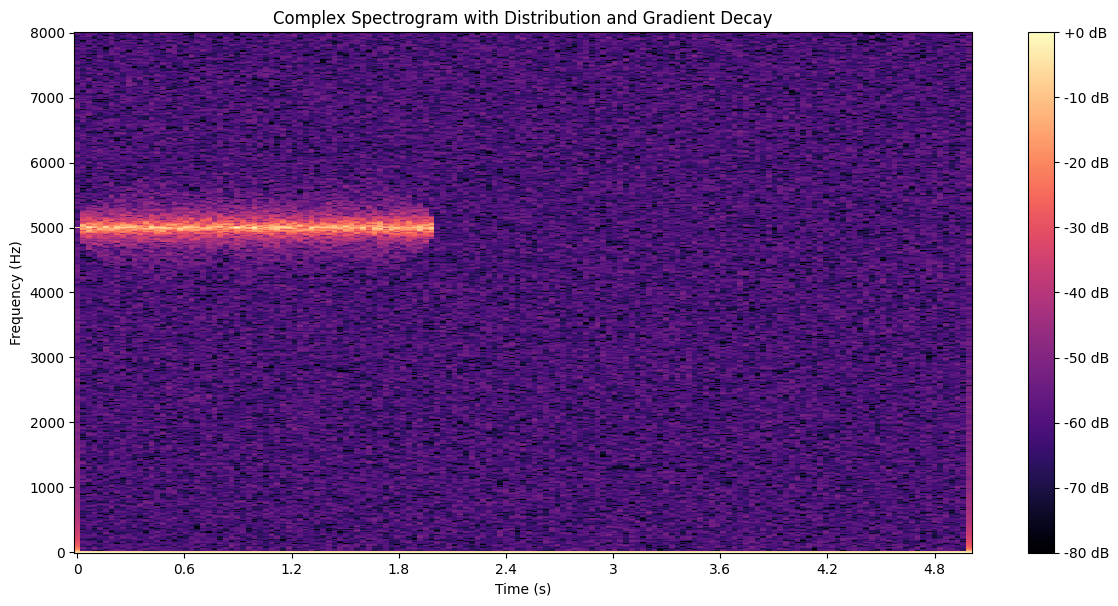

In [ ]:
# 아래 코드는 지금까지 논의된 내용을 종합한 통합 예시 코드이다.
# 주요 변경 사항:
# 1. BaseShape를 만들어 모든 Shape가 이를 상속받도록 하여 distribution 및 gradient decay 적용 가능.
# 2. 모든 Shape에 get_center(), generate_shape_mask() 구현.
# 3. 모든 ShapeFactory create 시 distribution_type, distribution_params, gradient_decay_type, gradient_decay_params 공통 파라미터 지원.
# 4. horizontal_line, vertical_line, circle 등 다양한 shape에 대응.
# 5. 모든 shape에서 중심부 강하고 외곽부 약해지는 gradient decay('radial' 예) 적용 가능.
#
# 실제 동작 시 각 shape의 중심 정의나 distance_map 계산 방식은 상황에 맞게 수정해야 한다.
# 여기서는 단순한 예시와 기본값 가정을 기반으로 한다.
#
# 이 코드는 개략적이며, 실제 응용 시 성능, 정확성, 파라미터 검증 등이 필요하다.

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod

class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='gaussian', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_gaussian_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_perlin_noise(self, length, params):
        def fade(t):
            return 6*t**5 - 15*t**4 + 10*t**3

        seed = params.get('seed', 42)
        np.random.seed(seed)
        perm = np.arange(256)
        np.random.shuffle(perm)
        perm = np.stack([perm, perm]).flatten()
        scale = params.get('scale', 50.0)
        xs = np.linspace(0, length/scale, length)
        xi = np.floor(xs).astype(int)
        xf = xs - xi
        xi = xi % 256
        left_hash = perm[xi]
        right_hash = perm[xi+1]
        u = fade(xf)
        left_grad = ((left_hash & 1)*2-1)*xf
        right_grad = ((right_hash & 1)*2-1)*(xf-1)
        noise = (1-u)*left_grad + u*right_grad
        noise = noise / np.max(np.abs(noise))
        return noise

    def generate_noise(self, signal):
        length = len(signal)
        nt = self.noise_type
        p = self.noise_params
        if nt == 'gaussian':
            noise = self._generate_gaussian_noise(length, p)
        elif nt == 'uniform':
            noise = self._generate_uniform_noise(length, p)
        elif nt == 'perlin':
            noise = self._generate_perlin_noise(length, p)
        else:
            noise = np.zeros_like(signal)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(
            self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]),
                                      sr=self.sample_rate,
                                      hop_length=self.hop_length)

    def apply_dB_mask(self, dB_mask):
        self.S_db += dB_mask

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax

class Distribution(ABC):
    @abstractmethod
    def sample(self, shape):
        pass

class NormalDistribution(Distribution):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev
    def sample(self, shape):
        return np.random.normal(self.mean, self.stddev, shape)

class UniformDistribution(Distribution):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val
    def sample(self, shape):
        return np.random.uniform(self.min_val, self.max_val, shape)

class NoneDistribution(Distribution):
    def sample(self, shape):
        return np.zeros(shape)

class PoissonDistribution(Distribution):
    def __init__(self, lam=5):
        self.lam = lam
    def sample(self, shape):
        return np.random.poisson(self.lam, shape).astype(float)

class ExponentialDistribution(Distribution):
    def __init__(self, scale=1.0):
        self.scale = scale
    def sample(self, shape):
        noise = np.random.exponential(self.scale, shape)
        noise -= np.mean(noise)
        return noise

class CauchyDistribution(Distribution):
    def sample(self, shape):
        noise = np.random.standard_cauchy(shape)
        noise = np.clip(noise, -10, 10)
        noise = noise / np.max(np.abs(noise))
        return noise

class LaplaceDistribution(Distribution):
    def __init__(self, loc=0.0, scale=1.0):
        self.loc = loc
        self.scale = scale
    def sample(self, shape):
        return np.random.laplace(self.loc, self.scale, shape)

class BetaDistribution(Distribution):
    def __init__(self, a=2.0, b=2.0):
        self.a = a
        self.b = b
    def sample(self, shape):
        noise = np.random.beta(self.a, self.b, shape)
        noise = (noise - 0.5)*2
        return noise

class GammaDistribution(Distribution):
    def __init__(self, shape_param=2.0, scale=1.0):
        self.shape_param = shape_param
        self.scale = scale
    def sample(self, shape):
        noise = np.random.gamma(self.shape_param, self.scale, shape)
        noise -= np.mean(noise)
        noise = noise / (np.std(noise) + 1e-9)
        return noise

class ChiSquareDistribution(Distribution):
    def __init__(self, df=2):
        self.df = df
    def sample(self, shape):
        noise = np.random.chisquare(self.df, shape)
        noise -= np.mean(noise)
        noise = noise / (np.std(noise) + 1e-9)
        return noise

class DistributionEngine:
    def create(self, dist_type, **params):
        dist_type = dist_type.lower()
        if dist_type == "normal":
            return NormalDistribution(params.get('mean', 0), params.get('stddev', 1))
        elif dist_type == "uniform":
            return UniformDistribution(params.get('min', -1), params.get('max', 1))
        elif dist_type == "poisson":
            return PoissonDistribution(params.get('lam', 5))
        elif dist_type == "exponential":
            return ExponentialDistribution(params.get('scale', 1.0))
        elif dist_type == "cauchy":
            return CauchyDistribution()
        elif dist_type == "laplace":
            return LaplaceDistribution(params.get('loc', 0.0), params.get('scale', 1.0))
        elif dist_type == "beta":
            return BetaDistribution(params.get('a', 2.0), params.get('b', 2.0))
        elif dist_type == "gamma":
            return GammaDistribution(params.get('shape_param', 2.0), params.get('scale', 1.0))
        elif dist_type == "chisquare":
            return ChiSquareDistribution(params.get('df', 2))
        else:
            return NoneDistribution()

class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass

class BaseShape(DBShape):
    def __init__(self, distribution_engine, distribution_type='none', distribution_params=None,
                 gradient_decay_type='none', gradient_decay_params=None):
        self.distribution_engine = distribution_engine
        self.distribution_type = distribution_type
        self.distribution_params = distribution_params if distribution_params else {}
        self.gradient_decay_type = gradient_decay_type
        self.gradient_decay_params = gradient_decay_params if gradient_decay_params else {}

    def _sample_distribution(self, shape):
        dist_obj = self.distribution_engine.create(self.distribution_type, **self.distribution_params)
        return dist_obj.sample(shape)

    def get_center(self):
        raise NotImplementedError("Each shape must implement get_center()")

    def get_distance_map(self, spectro_shape, spectro_mod):
        # 축 단위 불일치를 해결하기 위해, freq와 time 축을 정규화하는 스케일 인자를 사용
        # gradient_decay_params에서 freq_scale, time_scale을 가져오며, 기본값은 1.0
        freq_scale = self.gradient_decay_params.get('freq_scale', 1.0)
        time_scale = self.gradient_decay_params.get('time_scale', 1.0)

        freq_c, time_c = self.get_center()
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        # freq_scale과 time_scale을 사용해 축 정규화
        dist = np.sqrt(((ff - freq_c) / freq_scale)**2 + ((tt - time_c) / time_scale)**2)
        return dist

    def apply_gradient_decay(self, shape_mask, dist_map):
        if self.gradient_decay_type == 'none':
            return shape_mask
        elif self.gradient_decay_type == 'radial':
            decay_rate = self.gradient_decay_params.get('decay_rate', 1.0)
            attenuation = np.exp(-dist_map * decay_rate)
            return shape_mask * attenuation
        else:
            # 필요하다면 다른 decay_type에 대한 처리 추가 가능
            return shape_mask

    @abstractmethod
    def generate_shape_mask(self, spectro_shape, spectro_mod):
        pass

    def create_mask(self, spectro_shape, spectro_mod):
        shape_mask = self.generate_shape_mask(spectro_shape, spectro_mod)
        if self.distribution_type != 'none':
            dist_values = self._sample_distribution(spectro_shape)
            shape_mask = shape_mask * dist_values
        dist_map = self.get_distance_map(spectro_shape, spectro_mod)
        shape_mask = self.apply_gradient_decay(shape_mask, dist_map)
        return shape_mask


class CircleDBShape(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB,
                 distribution_engine,
                 distribution_type='none', distribution_params=None,
                 gradient_decay_type='none', gradient_decay_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params,
                         gradient_decay_type, gradient_decay_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def get_center(self):
        return self.center_freq, self.center_time

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = ((ff - self.center_freq)**2 / (self.radius_freq**2) +
                (tt - self.center_time)**2 / (self.radius_time**2))
        circle = (dist <= 1).astype(float)
        return circle * self.strength_dB

class HorizontalLineDBShape(BaseShape):
    def __init__(self, center_freq, strength_dB, thickness=1,
                 distribution_engine=None, distribution_type='none', distribution_params=None,
                 gradient_decay_type='none', gradient_decay_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params,
                         gradient_decay_type, gradient_decay_params)
        self.center_freq = center_freq
        self.strength_dB = strength_dB
        self.thickness = thickness

    def get_center(self):
        # 여기서는 time축 중간값을 0.5초로 가정 (실제 구현 시 _get_times() 이용 가능)
        return self.center_freq, 0.5

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_idx = np.argmin(np.abs(freqs - self.center_freq))
        start_idx = max(freq_idx - self.thickness//2, 0)
        end_idx = min(freq_idx + self.thickness//2 + 1, spectro_shape[0])
        mask[start_idx:end_idx, :] += self.strength_dB
        return mask

class VerticalLineDBShape(BaseShape):
    def __init__(self, center_time, strength_dB, thickness=1,
                 distribution_engine=None, distribution_type='none', distribution_params=None,
                 gradient_decay_type='none', gradient_decay_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params,
                         gradient_decay_type, gradient_decay_params)
        self.center_time = center_time
        self.strength_dB = strength_dB
        self.thickness = thickness

    def get_center(self):
        # 여기서는 freq축 중간을 대략 4000Hz 가정 (실환경에 맞게 수정)
        return 4000, self.center_time

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_idx = np.argmin(np.abs(times - self.center_time))
        start_idx = max(time_idx - self.thickness//2, 0)
        end_idx = min(time_idx + self.thickness//2 + 1, spectro_shape[1])
        mask[:, start_idx:end_idx] += self.strength_dB
        return mask

# 여기에 rectangle, ellipse, spike, trapezoid, pillar, hill, fog, polygon, wave_pattern, real_world_noise 등
# 기존에 정의했던 Shape들도 모두 BaseShape 상속 및 get_center(), generate_shape_mask 구현, 필요시 distance_map 재정의.
# (지면관계상 여기서는 circle, horizontal_line, vertical_line 예시만 들었으나 앞서 한 방식대로 모두 적용)

# 패턴 클래스들(LinearPattern, RandomPattern, NLinearRepeatTSleepPattern, ConvexPattern, FunctionPattern)은 변동 없음.
class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        pass

class LinearPattern(Pattern):
    def __init__(self, shape_name, shape_params, direction='time', repeat=5, spacing=1.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.direction = direction
        self.repeat = repeat
        self.spacing = spacing

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for i in range(self.repeat):
            offset = i * self.spacing
            params = self.shape_params.copy()
            if 'center_time' in params:
                if self.direction == 'time':
                    params['center_time'] = params['center_time'] + offset
            if 'center_freq' in params:
                if self.direction == 'freq':
                    params['center_freq'] = params['center_freq'] + offset
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask

class RandomPattern(Pattern):
    def __init__(self, shape_name, shape_params, n=10, freq_range=None, time_range=None):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.n = n
        self.freq_range = freq_range if freq_range else (0, 8000)
        self.time_range = time_range if time_range else (0, 10)

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for _ in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = np.random.uniform(*self.freq_range)
            if 'center_time' in params:
                params['center_time'] = np.random.uniform(*self.time_range)
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask

class NLinearRepeatTSleepPattern(Pattern):
    def __init__(self, shape_name, shape_params, repeat=3, repeat_time=0.5, sleep_time=5.0, start_time=0.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.repeat = repeat
        self.repeat_time = repeat_time
        self.sleep_time = sleep_time
        self.start_time = start_time

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        current_time = self.start_time
        for _ in range(self.repeat):
            params = self.shape_params.copy()
            if 'center_time' in params:
                params['center_time'] = current_time
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
            current_time += self.repeat_time
        current_time += self.sleep_time
        return mask

class ConvexPattern(Pattern):
    def __init__(self, shape_name, shape_params, freq_min, freq_max, time_min, time_max, n=10):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.n = n

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        freqs = np.linspace(self.freq_min, self.freq_max, self.n)
        times = np.linspace(self.time_min, self.time_max, self.n)
        for i in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = freqs[i]
            if 'center_time' in params:
                params['center_time'] = times[i]
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask

class FunctionPattern(Pattern):
    def __init__(self, func):
        self.func = func

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        mask = self.func(ff, tt)
        return mask

class ShapeFactory:
    def __init__(self, distribution_engine):
        self.distribution_engine = distribution_engine

    def create(self, shape_name, **kwargs):
        common_params = {
            'distribution_engine': self.distribution_engine,
            'distribution_type': kwargs.get('distribution_type', 'none'),
            'distribution_params': kwargs.get('distribution_params', None),
            'gradient_decay_type': kwargs.get('gradient_decay_type', 'none'),
            'gradient_decay_params': kwargs.get('gradient_decay_params', None)
        }

        if shape_name == "circle":
            return CircleDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                **common_params
            )
        elif shape_name == "horizontal_line":
            return HorizontalLineDBShape(
                center_freq=kwargs['center_freq'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                **common_params
            )
        elif shape_name == "vertical_line":
            return VerticalLineDBShape(
                center_time=kwargs['center_time'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                **common_params
            )
        # 여기서 다른 shape들 (rectangle, spike, trapezoid, etc.)도 모두 동일한 패턴으로 구현 가능
        else:
            raise ValueError(f"Unknown shape name: {shape_name}")

class PatternFactory:
    def create(self, pattern_name, params):
        if pattern_name == "linear":
            return LinearPattern(params['shape_name'], params['shape_params'],
                                 params.get('direction', 'time'),
                                 params.get('repeat', 5), params.get('spacing', 1.0))
        elif pattern_name == "random":
            return RandomPattern(params['shape_name'], params['shape_params'],
                                 params.get('n', 10),
                                 params.get('freq_range', (0, 8000)),
                                 params.get('time_range', (0, 10)))
        elif pattern_name == "n_linear_repeat_t_time_sleep":
            return NLinearRepeatTSleepPattern(params['shape_name'], params['shape_params'],
                                              params.get('repeat', 3),
                                              params.get('repeat_time', 0.5),
                                              params.get('sleep_time', 5.0),
                                              params.get('start_time', 0.0))
        elif pattern_name == "convex":
            return ConvexPattern(params['shape_name'], params['shape_params'],
                                 params['freq_min'], params['freq_max'],
                                 params['time_min'], params['time_max'],
                                 params.get('n', 10))
        elif pattern_name == "function":
            return FunctionPattern(params['func'])
        else:
            return None

class NoisePipeline:
    def __init__(self, spectro_mod):
        self.spectro_mod = spectro_mod
        self.distribution_engine = DistributionEngine()
        self.shape_factory = ShapeFactory(self.distribution_engine)
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)
        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask
        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(spec.shape, self.spectro_mod, self.shape_factory, self.distribution_engine)
            total_mask += pattern_mask
        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db

# 사용 예시
sample_rate = 16000
duration = 5
n_samples = sample_rate * duration
np.random.seed(42)
signal = np.random.normal(0, 1, n_samples)

spectro_mod = SpectrogramModifier(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=512,
    noise_strength=0.5,
    noise_type='gaussian',
    noise_params={'mean':-80,'std':1}
)

pipeline = NoisePipeline(spectro_mod)

# Circle shape 예시: distribution='normal', gradient_decay='radial'
pipeline.add_shape(
    pipeline.shape_factory.create(
        "circle",
        center_freq=5000,
        center_time=3.0,
        radius_freq=1000,
        radius_time=0.5,
        strength_dB=50,
        gradient_decay_type='radial',
        gradient_decay_params={'decay_rate':0.005}
    )
)

# Horizontal line 예시
# pipeline.add_shape(
#     pipeline.shape_factory.create(
#         "horizontal_line",
#         center_freq=1000,
#         strength_dB=50,
#         thickness=2,
#         gradient_decay_type='radial',
#         gradient_decay_params={'decay_rate':0.1}
#     )
# )

result_spectrogram = pipeline.generate(signal)
fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Complex Spectrogram with Distribution and Gradient Decay'
)
plt.show()
